Подключаем необходимые библиотеки

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as bs_compare
from bootstrapped import stats_functions as bs_stats

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)

sys.path.insert(0,nb_path)

Mounted at /content/drive


In [3]:
!pip install --target=$nb_path bootstrapped

     |████████████████████████████████| 10.3 MB 33.4 MB/s 
     |████████████████████████████████| 15.7 MB 56 kB/s 
     |████████████████████████████████| 11.3 MB 69.5 MB/s 
     |████████████████████████████████| 1.1 MB 70.5 MB/s 
     |████████████████████████████████| 3.1 MB 7.2 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 247 kB 59.0 MB/s 
     |████████████████████████████████| 503 kB 59.3 MB/s 
  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13954 sha256=e328a50939d5d78b61ae435c5ddfc5eb9c25d56dc8a6b55a4f7eccc67ac42edc
  Stored in directory: /root/.cache/pip/wheels/15/55/6a/9a722f067ac4c3dfab359ed2ec7906b9cc6649156d9886bd59
Successfully built bootstrapped
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have nump

## Загрузка данных

Получаем данные из файлов: данные по бакетам и по пользователям, и смотрим на них

In [ ]:
abt_by_bucket = pd.read_csv('hw_abt_2_bybucket.csv', sep = '\t', index_col=0)
abt_by_user = pd.read_csv('hw_abt_2_byuser.csv', sep = '\t', index_col=0)

In [ ]:
abt_by_bucket.head()

,metric_value,users,visits,churn_users,churn_visits
group_id,,,,,
1,1875345.0,155,1419,151,2207
2,1662237.0,138,1320,127,1853
3,1784372.0,128,1281,159,2032
4,1876826.0,163,1644,168,2172
5,1913180.0,156,1675,174,2273


In [ ]:
abt_by_user.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
2,10,8261.976,1,10,1,8,B
3,4,5522.000,1,9,1,7,A
4,16,5075.976,1,6,0,8,B


Выделяем отдельно данные по группе А и по группе B <br>
Затем выделяем данные столбца metric_value для дальнейшего исследования на нормальность и дисперсию <br>
Также сразу смотрим на гистограммы полученных выборок

In [ ]:
A_distr = abt_by_user[abt_by_user.group=='A']
B_distr = abt_by_user[abt_by_user.group=='B']

## Анализ метрики metric_value

In [ ]:
A_distr_metric = A_distr.metric_value
B_distr_metric = B_distr.metric_value

<AxesSubplot:xlabel='metric_value', ylabel='Count'>

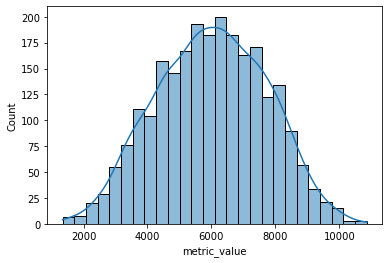

In [ ]:
sns.histplot(data=A_distr_metric, kde=True)

<AxesSubplot:xlabel='metric_value', ylabel='Count'>

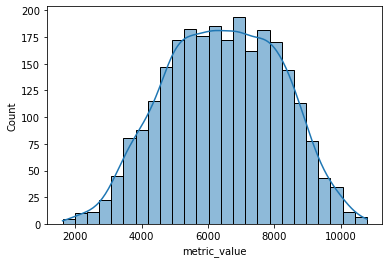

In [ ]:
sns.histplot(data=B_distr_metric, kde=True)